In [ ]:
#@title Aprendizaje Profundo | Otoño 2021 by Datitos{display-mode: "form" }
#@markdown ![71335171.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAACwElEQVR4nOzdMY7iQBBA0WU197/FnJNNJ/FqWvLHZfd7McIGfVVQos3X+/3+A2f7e/UN8EzCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBJfV9/A/7xer6XX3/1/gZ70eU0sEsIiISwSwiIhLBLCIiEsEiP2WEf7m9U9zVnvU9vh85pYJIRFQlgkhEVCWCSERUJYJEbssc5ytL+5at8zec9UM7FICIuEsEgIi4SwSAiLhLBIPGqPdWR1v1VfdwcmFglhkRAWCWGREBYJYZEQFokt9lhHdt4z1UwsEsIiISwSwiIhLBLCIiEsEh/dY+18zq4w7RzlTyYWCWGREBYJYZEQFglhkRAWiS1+jzVhr/Mbd7nP3zCxSAiLhLBICIuEsEgIi4SwSDxqj1U/72r1ulc9l2sCE4uEsEgIi4SwSAiLhLBICIvE7D3W9/fSy6/63dLqdZfvc/F7mMDEIiEsEsIiISwSwiIhLBLCIjF7j3WSs87rTXufyUwsEsIiISwSwiIhLBLCIiEsEq8Ju5N6r3OXc3xP2oeZWCSERUJYJIRFQlgkhEVCWCRG7LGOTN7TfNIdvwcTi4SwSAiLhLBICIuEsEgIi8Toc4U7Pyf9p8n7qiMmFglhkRAWCWGREBYJYZEQFonRe6wjd9zr7MbEIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIi8S8AAP//HtRtH09JwIEAAAAASUVORK5CYII=)
#El siguiente notebook fue traducido por Pablo Marinozi como el séptimo trabajo práctico correspondiente a la versión de Otoño del 2021 del curso Aprendizaje Profundo organizado por Datitos
#El tutorial original fue diseñado por Ben Trevett y fue publicado en su github https://github.com/bentrevett
#Para mayor información consultar https://datitos.github.io/curso-aprendizaje-profundo/#calendario

#Trabajo Práctico N° 8: Aprendizaje Secuencia a Secuencia con Transformers

## Todo lo que necesitas es prestar atención

En este práctico implementaremos una (versión ligeramente modificada) del modelo Transformer del paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). Todas las imágenes de este notebook se tomaron del paper de Transformer. Para obtener más información sobre el Transformer, [mirá](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [estos](https://jalammar.github.io/illustrated-transformer/) [tres](http://nlp.seas.harvard.edu/2018/04/03/attention.html) artículos.

![](https://i.imgur.com/umPkXYX.png)

## Introducción

Los Transformers no utilizan ningún tipo de recurrencia. En cambio, el modelo está compuesto por capas lineales, mecanismos de atención y normalización.

Al momento de creación de este práctico (Junio del 2021), los Transformers son la arquitectura dominante en NLP, se utilizan para lograr resultados del estado del arte en muchas tareas y parece que se seguirán utilizando en un futuro próximo.

La variante de Transformer más popular es [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) y sus versiones pre-entrenadas se utilizan comúnmente para reemplazar las capas de incrustación, si no más, en los modelos de NLP.

Las diferencias entre la implementación en este notebook y el paper son:
- utilizamos una codificación posicional aprendida en lugar de una estática
- utilizamos el optimizador Adam estándar con una tasa de aprendizaje estático en lugar de uno con pasos de calentamiento y enfriamiento
- no usamos suavizado de etiquetas.

Realizamos todos estos cambios ya que siguen de cerca la configuración de BERT y la mayoría de las variantes de Transformer utilizan una configuración similar.

## Preparando los datos

Como siempre, importemos todos los módulos necesarios y establezcamos las semillas aleatorias para la reproducibilidad.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Luego vamos a crear nuestros tokenizadores como antes.

In [3]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [4]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Nuestros Fields son los mismos que en el trabajo práctico anterior. El modelo espera que los datos se introduzcan primero con la dimensión del lote, por lo que usamos `batch_first = True`. 

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Luego cargamos el dataset Multi30k y construimos el vocabulario.

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.29MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 248kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 235kB/s]


In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Finalmente, definimos el `device` y el iterador de datos.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Capas Necesarias para el Modelo

Antes de armar el modelo, vamos a explicar algunas capas introducidas en el paper que forman una parte esencial tanto dentro del encoder como del decoder.

### Capa de atención de múltiples cabezales

Uno de los conceptos clave y novedosos introducidos por el documento Transformer es la *capa de atención de múltiples cabezales*. 

![](https://i.imgur.com/CwYzPgi.png)

La atención se puede considerar como ***consultas (queries)***, ***claves (keys)*** y ***valores (values)***, donde la consulta se usa junto a la clave para obtener un vector de atención (generalmente el resultado de una operación *softmax* y tiene todos los valores entre 0 y 1 que suma a 1) que luego se usa para obtener una suma ponderada de los valores.

El Transformer utiliza ***atención de producto punto escalada***, donde la consulta y la clave se combinan tomando el producto punto entre ellas, luego aplicando softmax y escalando por $d_k$ antes de finalmente multiplicar por el valor. La constante $ d_k $ es la ***dimensión de la cabeza***, `head_dim`, que explicaremos con más detalle en breve.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

Esto es similar a la ***atención de producto punto*** estándar pero escalada por $ d_k $, que según el documento se usa para evitar que los resultados de los productos punto se hagan demasiado grandes, y por lo tanto los gradientes se vuelvan demasiado pequeños.

Sin embargo, la atención de producto punto escalada no se aplica simplemente a las consultas, claves y valores. En lugar de realizar una aplicación de atención única, las consultas, claves y valores tienen su `hid_dim` dividido en ***$ h $ cabezas*** y la atención de producto punto escalada se calcula sobre todas las cabezas en paralelo. Esto significa que en lugar de prestar atención a un concepto por aplicación de atención, prestamos atención a $ h $ conceptos. Luego, volvemos a combinar las cabezas en su forma `hid_dim`.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$ W ^ O $ es la capa densa aplicada al final de la capa de atención de múltiples cabezales, que llamaremos en el código `fc_o`. $ W ^ Q, W ^ K, W ^ V $ son las capas densas que en el código llamaremos `fc_q`,` fc_k` y `fc_v`.

Recorriendo el código del módulo, primero calculamos $ QW ^ Q $, $ KW ^ K $ y $ VW ^ V $ con las capas lineales, `fc_q`, ` fc_k` y `fc_v`, para darnos ` Q`, ` K` y `V`. A continuación, dividimos el `hid_dim` de la consulta, la clave y el valor en ` n_heads` usando `.view()` y los permutamos correctamente para que se puedan multiplicar juntos. Luego calculamos la `energía` (la atención no normalizada) multiplicando ` Q` y `K` y escalando por la raíz cuadrada de` head_dim`, que se calcula como `hid_dim // n_heads`. Luego enmascaramos la energía para que no prestemos atención a ningún elemento de la secuencia que no deberíamos, luego aplicamos el softmax y dropout. A continuación, aplicamos la atención a los valores de los cabezales, `V`, antes de combinar los resultados para las ` n_heads` . Finalmente, multiplicamos este $ W ^ O $, representado por `fc_o`.

Tenga en cuenta que en nuestra implementación las longitudes de las claves y los valores son siempre los mismos, por lo tanto, cuando la matriz multiplica la salida del softmax, `attention`, con` V` siempre tendremos tamaños de dimensión válidos para la multiplicación de matrices. Esta multiplicación se lleva a cabo usando `torch.matmul` que, cuando ambos tensores son >2-dimensionales, hace una multiplicación matricial por lotes sobre las dos últimas dimensiones de cada tensor. Esto será una multiplicación de matriz por lotes con formas **[query len, key len] x [value len, head dim]**   sobre el tamaño de lote y cada cabezal que proporciona un resultado con forma **[batch size, n heads, query len, head dim]** .

Algo que parece extraño al principio es que el dropout se aplica directamente a la atención. Esto significa que lo más probable es que nuestro vector de atención no sume 1 o que prestemos toda la atención a un solo token que puede establecerse en 0 por el dropout. Estos problemas nunca se explican, ni siquiera se mencionan, en el paper, sin embargo, es lo que se hace en la [implementación oficial](https://github.com/tensorflow/tensor2tensor/) y todas las implementaciones de Transformer desde entonces, [incluido BERT](https://github.com/google-research/bert/).

In [11]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Capa Feed-Forward Posicional 

La otra capa presentada en el paper es la *capa feedforward posicional*. Esta capa es relativamente simple en comparación con la capa de atención de múltiples cabezales. La entrada se transforma de `hid_dim` a` pf_dim`, donde `pf_dim` suele ser mucho más grande que` hid_dim`. El Transformer original usó un `hid_dim` de 512 y un` pf_dim` de 2048. La función de activación de ReLU y el dropout se aplican antes de que se vuelva a transformar en una representación de `hid_dim`.

BERT usa la función de activación [GELU](https://arxiv.org/abs/1606.08415), que se puede usar simplemente cambiando `torch.relu` por` F.gelu`. 

In [12]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

## Construyendo el modelo

A continuación, crearemos el modelo. Al igual que en el trabajo práctico anterior, se compone de un *encoder* y un *decoder*, con el encoder *codificando* la oración de entrada/origen (en alemán) en un *vector de contexto* y el decoder luego *decodificando* este vector de contexto para generar nuestra oración de salida/objetivo (en inglés).

### Bloque Encoder 

Los bloques Encoder son donde se encuentra toda la "magia" del Encoder. 

![](https://i.imgur.com/adzmIfx.png)

Primero pasamos la oración origen y su máscara a la *capa de atención de múltiples cabezales*, luego aplicamos dropout, una conexión residual y una capa de  [Normalización por capas](https://arxiv.org/abs/1607.06450 ). Luego lo pasamos a través de una capa feed-forward posicional y luego, nuevamente, aplicamos dropout, una conexión residual y  la capa de normalización por capas para obtener la salida de este bloque que se alimenta al siguiente bloque. Los parámetros no se comparten entre bloques.

La capa de atención de múltiples cabezales es utilizada por el bloque encoder para prestar atención a la oración origen, es decir, está calculando y aplicando atención sobre sí misma en lugar de otra secuencia, por lo que la llamamos *auto-atención*.

[Este](https://becominghuman.ai/all-about-normalization-6ea79e70894b) artículo entra en más detalles sobre la normalización de capas, pero la esencia es que normaliza los valores de las features, de manera que cada feature tiene una media de 0 y una desviación estándar de 1. Esto permite que las redes neuronales con una mayor número de capas, como el Transformer, puedan entrenar más fácilmente.

In [13]:
class AddNorm(nn.Module):
  def __init__(self, normalized_shape, dropout, **kwargs):
      super(AddNorm,self).__init__(**kwargs)

      self.dropout = nn.Dropout(dropout)
      self.ln = nn.LayerNorm(normalized_shape)

  def forward(self,X,Y):

      return self.ln(self.dropout(Y) + X)

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim,dropout, device):

        #########################################################################
        #TO_DO: Configure las capas que necesita para el bloque encoder con la         #
        #       arquitectura definida anteriormente.                            #
        #########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) ***** 
        super(EncoderBlock,self).__init__()

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        self.dropout = dropout
        self.device = device

        self.attention = MultiHeadAttentionLayer(self.hid_dim, self.n_heads, self.dropout,self.device)
        self.positional = PositionwiseFeedforwardLayer( self.hid_dim, self.pf_dim, self.dropout)
        self.addnorm_1 = AddNorm(self.hid_dim,self.dropout)
        self.addnorm_2 = AddNorm(self.hid_dim,self.dropout)

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################
        
    def forward(self, src, src_mask):
        ########################################################################
        # TODO: Implementá la función forward para el bloque encoder. Deberías #
        # usar las capas que definiste en __init__ y especificar la            #
        # conectividad de dichas capas                                         #
        ########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        X = self.addnorm_1(src, self.attention(src,src,src,src_mask)[0])
        src = self.addnorm_2(X, self.positional(X))

        

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################
        return src

### Encoder
El encoder del Transformer no intenta comprimir toda la oración fuente, $ X = (x_1, ..., x_n) $, en un solo vector de contexto, $ z $. En su lugar, produce una secuencia de vectores de contexto, $ Z = (z_1, ..., z_n) $. De esta manera, si nuestra secuencia de entrada tuviera 5 tokens de longitud, tendríamos $ Z = (z_1, z_2, z_3, z_4, z_5) $. ¿Por qué llamamos a esto una secuencia de vectores de contexto y no una secuencia de variables ocultas? Porque una variable oculta en el momento $ t $ en una RNN solo ha visto el token $ x_t $ y todos los tokens anteriores. Sin embargo, cada vector de contexto aquí ha visto todos los tokens en todas las posiciones dentro de la secuencia de entrada.

![](https://i.imgur.com/6gOHngA.png)

Primero, los tokens se pasan a través de una capa de embedding estándar. A continuación, como el modelo no tiene recurrencias, no tiene idea del orden de los tokens dentro de la secuencia. Resolvemos este problema usando una segunda capa de embedding llamada *capa de embedding posicional*. Esta es una capa de embedding estándar donde la entrada no es el token en sí, sino la posición del token dentro de la secuencia, comenzando con el primer token, el token `<sos>` (inicio de secuencia), en la posición 0. El embedding posicional tiene un tamaño de "vocabulario" de 100, lo que significa que nuestro modelo puede aceptar oraciones de hasta 100 tokens de longitud. Esto se puede aumentar si queremos manejar oraciones más largas.

La implementación del Transformer original del paper "Attention is All You Need" no aprende los embedding posicionales. En su lugar, utiliza una codificación posicional estática fija. Las arquitecturas modernas de Transformer, como BERT, usan embedding posicionales aprendibles en su lugar, por lo tanto, hemos decidido usarlos en este trabajo práctico. Consulte [esta](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) sección para leer más sobre la codificación posicional utilizada en el modelo Transformer original.

A continuación, el token y los embeddings posicionales se suman elemento a elemento para obtener un vector que contiene información sobre el token y también su posición en la secuencia. Sin embargo, antes de sumarlos, los embeddings de tokens se multiplican por un factor de escala que es $ \sqrt{d_{modelo}} $, donde $ d_{modelo} $ es la dimensión de las capas ocultas, `hid_dim`. Esto supuestamente reduce la variación en los embeddings y el modelo es difícil de entrenar de manera confiable sin este factor de escala. A continuación, se aplica  dropout a los embeddings combinados.

Los embeddings combinados se pasan a través de $ N $ de los ***bloques encoder***, definidos en la sección anterior, para obtener $ Z $, que luego se envía y puede ser utilizado por el decoder.

La máscara origen, `src_mask`, tiene simplemente la misma forma que la oración origen pero tiene un valor de 1 cuando el token en la oración origen no es un token` <pad> `y 0 cuando sí lo es. Esto se usa en las capas del encoder para enmascarar los mecanismos de atención de múltiples cabezales, que se usan para calcular y aplicar atención sobre la oración origen, para que el modelo no preste atención a los tokens `<pad>`, que no contienen información útil.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout,
                 device, max_length = 100):
        #########################################################################
        #TO_DO: Configure las capas que necesita para el encoder con la         #
        #       arquitectura definida anteriormente.                            #
        #########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) ***** 
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        self.dropout = dropout
        self.device = device
        self.max_length = max_length
        

        self.dropout_ = nn.Dropout(self.dropout)
        
        self.embedding = nn.Embedding(self.input_dim, self.hid_dim)
        
        self.embedding_posicional = nn.Parameter(torch.randn(1, self.max_length , self.hid_dim))

        self.blks = nn.Sequential()
        for i in range(self.n_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(self.hid_dim,
                             self.n_heads,
                             self.pf_dim,
                             self.dropout,
                             self.device,
                             )
                        )

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################
        
    def forward(self, src, src_mask):
        ########################################################################
        # TODO: Implementá la función forward para el encoder. Deberías        #
        # usar las capas que definiste en __init__ y especificar la            #
        # conectividad de dichas capas                                         #
        ########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        X = self.embedding(src) * math.sqrt(self.hid_dim)
        
        #pos = [batch size, src len]
        

        src = X + self.embedding_posicional.data[:, :X.shape[1], :]
        src = self.dropout_(src) 
        
        #src = [batch size, src len, hid dim]
        
        for i, blk in enumerate(self.blks):
            src = blk(src, src_mask)
            
        #src = [batch size, src len, hid dim]

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################        
            
        return src

### Bloque Decoder

El bloque decoder es similar al bloque encoder excepto que ahora tiene dos capas de atención de múltiples cabezales, `self_attention` y `encoder_attention`.

![](https://i.imgur.com/DjsYbBi.png)

La primera realiza la auto-atención, como en el encoder, utilizando la representación del decoder hasta el momento como consulta, clave y valor. A esto le sigue el dropout, la conexión residual y la normalización por capas. Esta capa `self_attention` usa la máscara de secuencia objetivo,` trg_mask`, para evitar que el decoder "haga trampas" prestando atención a los tokens que están "por delante" del que está procesando actualmente, ya que procesa en paralelo todos los tokens en la oración objetivo.

La segunda es la manera en que realmente alimentamos la oración origen codificada, `enc_src`, en nuestro decoder. En esta capa de atención de múltiples cabezales, las consultas son las representaciones del decoder hasta el momento y las claves y valores son las representaciones del encoder. Aquí, la máscara de origen, `src_mask` se usa para evitar que la capa de atención de múltiples cabezales preste atención a los tokens ` <pad> ` dentro de la oración de origen. A esto le siguen la capa de dropout, la conexión residual y la capa de normalización por capas. 

Finalmente, pasamos esto a través de la capa feed-forward posicional y otra secuencia de dropout, conexión residual y normalización por capa.

El bloque decoder no está introduciendo ningún concepto nuevo, solo usa el mismo conjunto de capas que el bloque encoder de una manera ligeramente diferente.

In [16]:
class DecoderBlock(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim,dropout, device):
        #########################################################################
        #TO_DO: Configure las capas que necesita para el bloque decoder con la  #
        #       arquitectura definida anteriormente.                            #
        #########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) ***** 

        super(DecoderBlock, self).__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        self.dropout = dropout
        self.device = device


        self.self_attention = MultiHeadAttentionLayer(self.hid_dim, self.n_heads, self.dropout,self.device)

        self.addnorm_1 = AddNorm(self.hid_dim, self.dropout)

        self.attention = MultiHeadAttentionLayer(self.hid_dim, self.n_heads, self.dropout,self.device)

        self.addnorm_2 = AddNorm(self.hid_dim, self.dropout)

        self.positional = PositionwiseFeedforwardLayer( self.hid_dim, self.pf_dim, self.dropout)

        self.addnorm_3 = AddNorm(self.hid_dim,self.dropout)


        
        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        ########################################################################
        # TODO: Implementá la función forward para el bloque decoder. Deberías #
        # usar las capas que definiste en __init__ y especificar la            #
        # conectividad de dichas capas                                         #
        ########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        x, attention = self.self_attention(trg,trg,trg,trg_mask)
        X = self.addnorm_1(trg, x)
        X_1, attention_1 = self.attention(X, enc_src, enc_src, src_mask)
        X_1 = self.addnorm_2(X, X_1)
            
        #trg = [batch size, trg len, hid dim]
            
        trg = self.addnorm_3(X_1, self.positional(X_1))

        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention_1

### Decoder

El objetivo del decoder es tomar la representación codificada de la oración origen, $ Z $, y convertirla en tokens predichos en la oración objetivo, $ \hat {Y} $. Luego comparamos $ \hat {Y} $ con los tokens reales en la oración objetivo, $ Y $, para calcular nuestra pérdida, que se usará para calcular los gradientes de nuestros parámetros y luego usamos nuestro optimizador para actualizar nuestros pesos de manera de mejorar nuestras predicciones.

![](https://i.imgur.com/g5Armz5.png)

El decoder es similar al encoder, sin embargo, tiene dos capas de atención de múltiples cabezales. Una *capa de auto-atención de múltiples cabezales enmascarada* sobre la secuencia objetivo, y una capa de atención de múltiples cabezales que usa la representación del decoder como consulta y la representación del encoder como clave y valor.

El decoder utiliza embedding posicionales y los combina, a través de una suma elemento a elemento, con los embeddings escalados de los tokens de destino, seguidos de dropout. Nuevamente, nuestros embeddings posicionales tienen un "vocabulario" de 100, lo que significa que pueden aceptar secuencias de hasta 100 tokens de longitud. Esto se puede aumentar si se desea.

Los embeddings combinados se pasan a través de $ N $ ***bloques decoder***,definidos en la sección anterior, junto con la frase origen codificada, `enc_src`, y las máscaras de origen y destino. Tenga en cuenta que la cantidad de bloques encoder no tiene que ser igual a la cantidad de bloques decoder, aunque ambas se denoten con $ N $.

La representación del decoder después del último bloque se pasa a través de una capa densa, `fc_out`. En PyTorch, la operación softmax está contenida dentro de nuestra función de pérdida, por lo que no necesitamos explícitamente usar una capa softmax aquí.

Además de usar la máscara de origen, como hicimos en el encoder para evitar que nuestro modelo preste atención a los tokens `<pad>`, también usamos una máscara de destino. Esto se explicará con más detalle en el modelo "Seq2Seq" que encapsula tanto el encoder como el decoder, pero lo esencial es que como estamos procesando todos los tokens de destino a la vez en paralelo, necesitamos un método para evitar que el decoder "haga trampa" simplemente "mirando" cuál es el siguiente token en la secuencia de destino y emitiéndolo como salida.

Nuestro decoder también genera los valores de atención normalizados para que luego podamos graficarlos para ver a qué está prestando atención nuestro modelo.

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, 
                 device,max_length = 100):
        #########################################################################
        #TO_DO: Configure las capas que necesita para el decoder con la         #
        #       arquitectura definida anteriormente.                            #
        #########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) ***** 

        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        self.dropout = dropout
        self.device = device
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_dim, self.hid_dim)

        self.embedding_posicional = nn.Parameter(torch.randn(1,self.max_length, self.hid_dim))

        self.dropout_= nn.Dropout(self.dropout)

        self.blks = nn.Sequential()
        for i in range(self.n_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(self.hid_dim,
                             self.n_heads,
                             self.pf_dim,
                             self.dropout,
                             self.device
                             )
                        )
            
        self.linear = nn.Linear(self.hid_dim, self.output_dim)
        

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        ########################################################################
        # TODO: Implementá la función forward para el decoder. Deberías        #
        # usar las capas que definiste en __init__ y especificar la            #
        # conectividad de dichas capas                                         #
        ########################################################################
        # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        X = self.embedding(trg) * math.sqrt(self.hid_dim)
                            
        #pos = [batch size, trg len]
            
        pos = self.embedding_posicional.data[:, :X.shape[1], :]

                
        #trg = [batch size, trg len, hid dim]

        trg = X + pos
        trg = self.dropout_(trg) 

        #attention = [batch size, n heads, trg len, src len]
        
        for i, blk in enumerate(self.blks):
            trg, attention = blk(trg, enc_src, trg_mask, src_mask)
            
        output = self.linear(trg)  
        
        #output = [batch size, trg len, output dim]

        # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
        ########################################################################
        #                          FINAL DE TU CÓDIGO                          #       
        ########################################################################

        return output, attention

### Seq2Seq

Finalmente, tenemos el módulo `Seq2Seq` que encapsula el encoder y decoder, además de manejar la creación de las máscaras.

La máscara de origen se crea comprobando dónde la secuencia de origen no es igual a un token `<pad>`. Es 1 cuando el token no es un token `<pad>` y 0 cuando lo es. Luego se hace un unsqueeze para que se pueda aplicar correctamente el broadcast al aplicar la máscara a la "energía", que tiene forma **_[batch size, n heads, seq len, seq len]_**.

La máscara de destino es un poco más complicada. Primero, creamos una máscara para los tokens `<pad>`, como hicimos para la máscara de origen. A continuación, creamos una máscara "subsecuente", `trg_sub_mask`, usando` torch.tril`. Esto crea una matriz diagonal donde los elementos por encima de la diagonal serán cero y los elementos por debajo de la diagonal se establecerán en lo que sea que valga el tensor de entrada. En este caso, el tensor de entrada será un tensor lleno de unos. Entonces esto significa que nuestro `trg_sub_mask` se verá así (para un objetivo con 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

Esto muestra lo que cada token de destino (fila) está autorizado a mirar (columna). El primer token de destino tiene una máscara de **_[1, 0, 0, 0, 0]_**, lo que significa que solo puede mirarse a sí mismo. El segundo token de destino tiene una máscara de **_[1, 1, 0, 0, 0]_**, lo que significa que puede ver el primer y el segundo token de destino.

A continuación, a la máscara "subsecuente" se le aplica un AND lógico con la máscara de relleno, esto combina las dos máscaras, lo que garantiza que no se puedan atender ni a los tokens posteriores ni a los tokens de relleno. Por ejemplo, si los dos últimos tokens fueran tokens `<pad>`, la máscara se vería así:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

Una vez creadas las máscaras, se utilizan con el encoder y el decoder junto con las oraciones de origen y destino para obtener nuestra oración de destino predicha, `output`, junto con la atención del decoder sobre la secuencia de origen.

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Entrenamiento del modelo Seq2Seq

Ahora podemos definir nuestro encoder y decoder. Este modelo es significativamente más pequeño que los Transformers que se utilizan en investigación hoy en día, pero se puede ejecutar rápidamente en una sola GPU.

In [19]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Luego, los utilizamos para definir todo nuestro modelo de secuencia a secuencia encapsulado.

In [20]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Podemos verificar el número de parámetros...

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


El documento no menciona qué esquema de inicialización de pesos se usó, sin embargo, Xavier parece ser común entre los modelos de Transformer, así que lo usamos aquí.

In [22]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
model.apply(initialize_weights);

El optimizador utilizado en el paper original de Transformer utiliza a Adam con una tasa de aprendizaje que tiene un período de "calentamiento" y luego un período de "enfriamiento". BERT y otros modelos de Transformer usan Adam con una tasa de aprendizaje fija, así que lo vamos a implementar así. Consulte  [este](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) enlace para obtener más detalles sobre la programación de la tasa de aprendizaje del Transformer original.

Tenga en cuenta que la tasa de aprendizaje debe ser más baja que la predeterminada utilizada por Adam o, de lo contrario, el aprendizaje es inestable.

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

A continuación, definimos nuestra función de pérdida, asegurándonos de ignorar las pérdidas calculadas sobre los tokens `<pad>`.

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Luego, vamos a definir nuestro ciclo de entrenamiento. 

Como queremos que nuestro modelo prediga el token `<eos>` pero que no sea una entrada en nuestro modelo, simplemente cortamos el token `<eos>` del final de la secuencia. Por lo tanto:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$ x_i $ denota el elemento real de la secuencia objetivo. Luego introducimos esto en el modelo para obtener una secuencia predicha que, con suerte, debería predecir el token `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$ y_i $ denota el elemento de secuencia objetivo predicho. Luego calculamos nuestra pérdida usando el tensor `trg` original con la ficha` <sos> ` eliminada del frente, dejando la ficha` <eos> `:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

Luego calculamos nuestras pérdidas y actualizamos nuestros parámetros como es estándar.

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

El ciclo de evaluación es el mismo que el ciclo de entrenamiento, solo que sin los cálculos de gradiente y las actualizaciones de parámetros.

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Luego definimos una pequeña función que podemos usar para decirnos cuánto tarda una época.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finalmente, entrenamos nuestro modelo. 

In [29]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 12m 21s
	Train Loss: 4.584 | Train PPL:  97.890
	 Val. Loss: 3.464 |  Val. PPL:  31.957
Epoch: 02 | Time: 12m 8s
	Train Loss: 3.262 | Train PPL:  26.111
	 Val. Loss: 2.666 |  Val. PPL:  14.376
Epoch: 03 | Time: 12m 5s
	Train Loss: 2.644 | Train PPL:  14.064
	 Val. Loss: 2.222 |  Val. PPL:   9.226
Epoch: 04 | Time: 12m 18s
	Train Loss: 2.246 | Train PPL:   9.448
	 Val. Loss: 1.968 |  Val. PPL:   7.154
Epoch: 05 | Time: 12m 0s
	Train Loss: 1.970 | Train PPL:   7.169
	 Val. Loss: 1.808 |  Val. PPL:   6.100
Epoch: 06 | Time: 11m 59s
	Train Loss: 1.766 | Train PPL:   5.848
	 Val. Loss: 1.703 |  Val. PPL:   5.493
Epoch: 07 | Time: 11m 57s
	Train Loss: 1.611 | Train PPL:   5.009
	 Val. Loss: 1.639 |  Val. PPL:   5.152
Epoch: 08 | Time: 11m 59s
	Train Loss: 1.488 | Train PPL:   4.426
	 Val. Loss: 1.589 |  Val. PPL:   4.899
Epoch: 09 | Time: 12m 1s
	Train Loss: 1.382 | Train PPL:   3.982
	 Val. Loss: 1.563 |  Val. PPL:   4.775
Epoch: 10 | Time: 11m 55s
	Train Loss: 1.291 | Tra

Cargamos nuestros "mejores" parámetros y logramos lograr una mejor perplejidad de prueba que todos los modelos que probamos en el modelo anterior.

In [30]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.615 | Test PPL:   5.026 |


## Inferencia

Ahora con nuestro modelo podemos realizar traducciones con la función `translate_sentence` a continuación.

Los pasos dados son:
- tokenizar la oración origen si no se ha tokenizado 
- añadir los tokens `<sos>` y `<eos>`
- numericalizar la oración fuente (asignarle un entero a cada token)
- convertir en un tensor y agregar una dimensión de lote
- crear la máscara de la oración fuente
- alimentar la frase origen y la máscara en el encoder
- crear una lista para contener la oración de salida, inicializada con un token `<sos>`
- mientras no hayamos alcanzado una longitud máxima
  - convertir la predicción actual de la oración de salida en un tensor con una dimensión de lote
  - crear una máscara de oración de destino
  - colocar la salida actual, la salida del encoder y ambas máscaras en el decoder
  - obtener la próxima predicción del token de salida del decoder junto con la atención
  - agregar predicción a la lista de predicciones de la oración de salida actual
  - meter un break si la predicción fue un token `<eos>`
- convertir la oración de salida de índices a tokens
- devolver la oración de salida (con el token `<sos>` eliminado) y la atención de la última capa

In [31]:
[TRG.init_token]

['<sos>']

In [32]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    #########################################################################
    #TO_DO: Siga los pasos anteriores para implementear la función que      #
    #       traduce una oración del alemán al inglés                        #
    #########################################################################
    # ***** INICIO DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) ***** 

    model.eval()
    if type(sentence) is not list: # SI VIENE EN UNA LISTA SUPONGO QUE YA ESTÁ TOKENIZADO
      token_sentense = SRC.tokenize(sentence)
    else: 
      token_sentense = sentence

    index_sentense = [src_field.vocab.stoi[token] for token in token_sentense] 
    index_sentense = [src_field.vocab.stoi[src_field.init_token]] + index_sentense + [src_field.vocab.stoi[src_field.eos_token]]

    tensor = torch.tensor(index_sentense).unsqueeze(0).to(device)
    origen_mask = model.make_src_mask(tensor).to(device)
    model.encoder.eval()
    origen = model.encoder(tensor, origen_mask).to(device)
    salida_indices = []
    salida_indices.append(trg_field.vocab.stoi[trg_field.init_token])
    
    for x in range(max_len):
      
       prediccion = torch.IntTensor(salida_indices).unsqueeze(0).to(device)
        
       salida_mask = model.make_trg_mask(prediccion).to(device)
       model.decoder.eval()
       output, attention = model.decoder(prediccion, origen, salida_mask, origen_mask)
      
       output = output.argmax(2)
       output = output[:,-1].item()
       print('output word', TRG.vocab.itos[output])

       salida_indices.append(output) 

       if output == trg_field.vocab.stoi[trg_field.eos_token]:
           break
  
    trg_tokens = [trg_field.vocab.itos[index] for index in salida_indices]

    # ***** FINAL DE TU CÓDIGO (NO BORRES NI MODIFIQUES ESTA LÍNEA) *****
    ########################################################################
    #                          FINAL DE TU CÓDIGO                          #       
    ########################################################################
    
    return trg_tokens[1:], attention

Ahora definiremos una función que muestra la atención sobre la oración fuente para cada paso de la decodificación. Como este modelo tiene 8 cabezales podemos ver la atención para cada una de ellos.

In [33]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Primero, obtendremos un ejemplo del conjunto de entrenamiento.

In [34]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Nuestra traducción se ve bastante bien, aunque nuestro modelo cambia *is walking by* por *walks by*. El significado sigue siendo el mismo.

In [35]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

output word a
output word woman
output word with
output word a
output word large
output word purse
output word walking
output word past
output word a
output word gate
output word .
output word <eos>
predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walking', 'past', 'a', 'gate', '.', '<eos>']


Podemos ver la atención de cada cabezal a continuación. Cada uno es ciertamente diferente, pero es difícil (quizás imposible) razonar sobre a qué ha aprendido realmente a prestar atención. Algunos cabezales prestan toda su atención a "eine" cuando traducen "a", otros no lo hacen en absoluto y otros lo hacen un poco. Todos parecen seguir el patrón similar de "escalera descendente" y la atención al sacar las dos últimas fichas se distribuye por igual entre las dos últimas fichas de la oración de entrada.

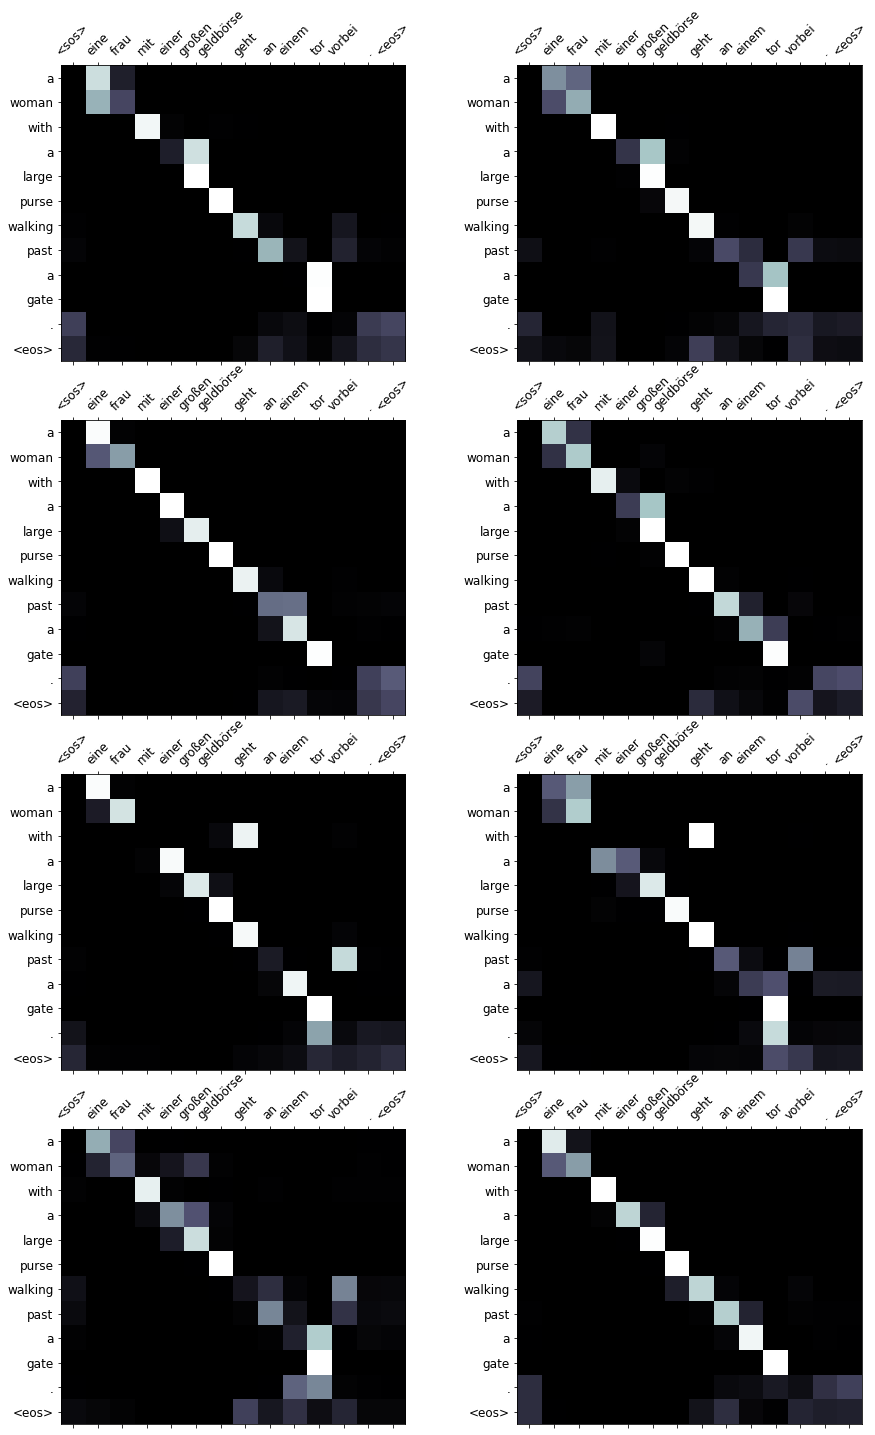

In [36]:
display_attention(src, translation, attention)

A continuación, obtengamos un ejemplo con el que no se ha entrenado el modelo desde el conjunto de validación.

In [37]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


El modelo lo traduce cambiando "*is running*" a simplemente "*runs*", pero es un intercambio aceptable.

In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

output word a
output word brown
output word dog
output word running
output word after
output word the
output word black
output word dog
output word .
output word <eos>
predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


Una vez más, algunos cabezales prestan total atención a "ein" mientras que otros no le prestan atención. Una vez más, la mayoría de los cabezales parecen extender su atención tanto al punto como a los tokens `<eos>` en la oración de origen cuando generan el punto y el token `<eos>` en la oración objetivo predicha, aunque algunos parecen prestar atención a tokens cercanos del comienzo de la oración.

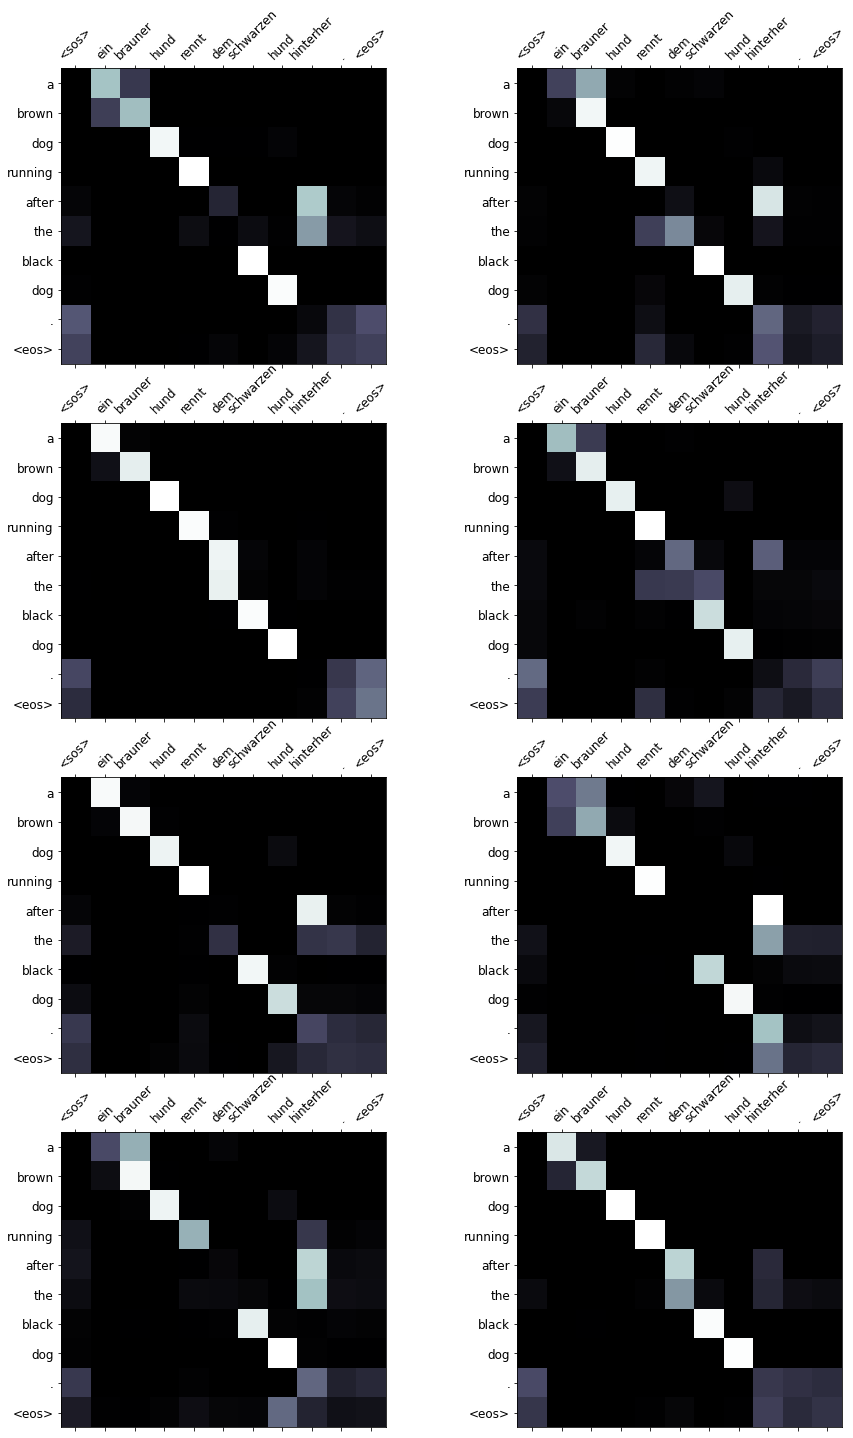

In [45]:
display_attention(src, translation, attention)

Finalmente, veremos un ejemplo de los datos de prueba.

In [46]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


¡Una traducción perfecta!

In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

output word a
output word mother
output word and
output word her
output word small
output word son
output word are
output word enjoying
output word a
output word beautiful
output word day
output word .
output word <eos>
predicted trg = ['a', 'mother', 'and', 'her', 'small', 'son', 'are', 'enjoying', 'a', 'beautiful', 'day', '.', '<eos>']


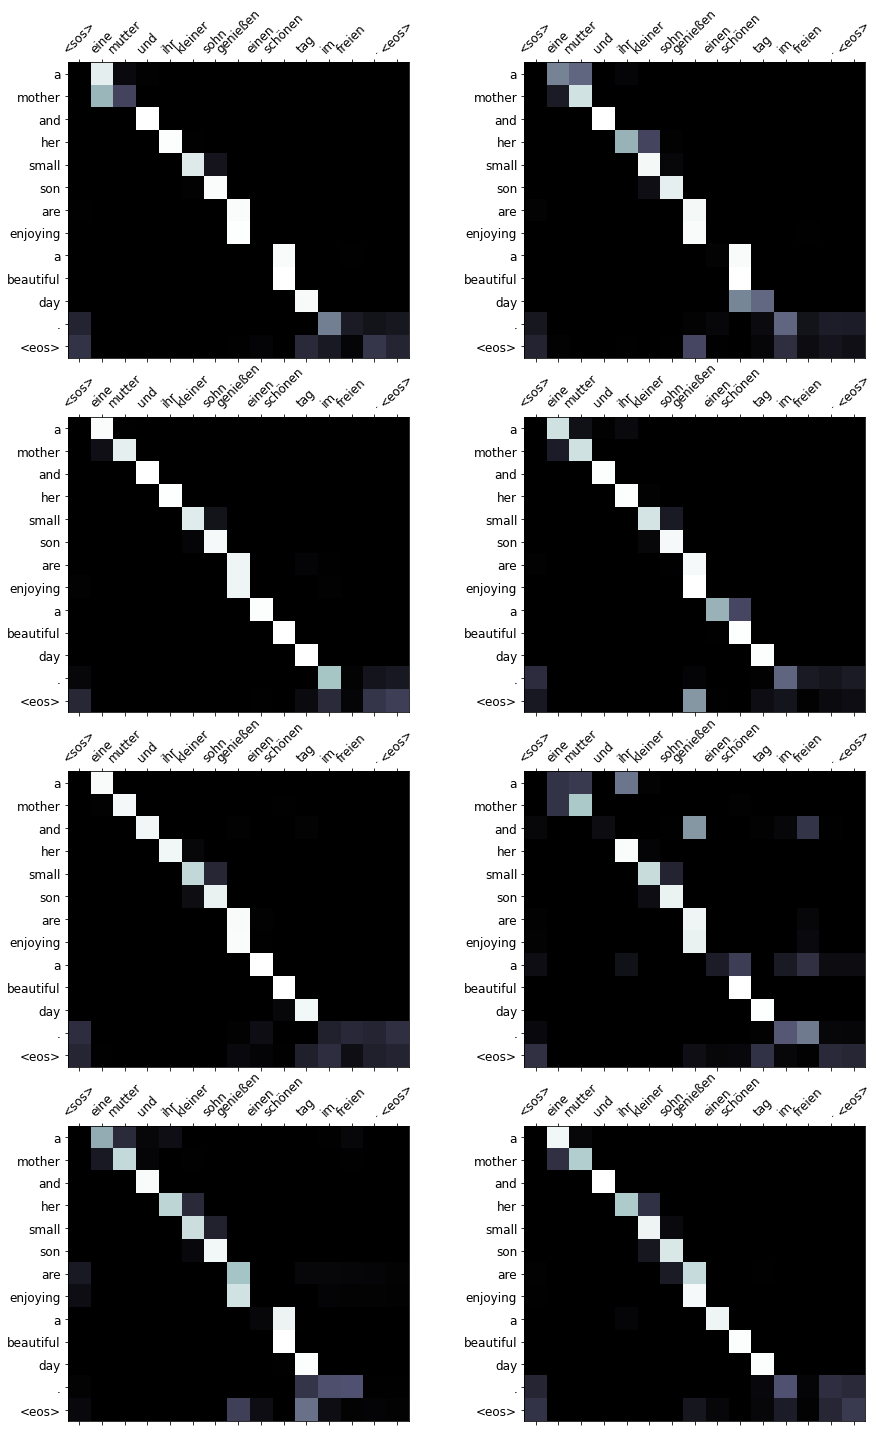

In [48]:
display_attention(src, translation, attention)

## BLEU

Finalmente calculamos el BLEU para el Transformer.

In [49]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

Obtenemos una puntuación BLEU de 36,52, que supera el  ~ 28 del modelo RNN basado en la atención. ¡Todo esto con la menor cantidad de parámetros y el tiempo de entrenamiento más rápido!

In [50]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

Streaming output truncated to the last 5000 lines.
output word .
output word <eos>
output word some
output word people
output word are
output word sitting
output word on
output word benches
output word under
output word a
output word building
output word surrounded
output word by
output word trees
output word .
output word <eos>
output word a
output word man
output word in
output word a
output word suit
output word sits
output word at
output word a
output word bus
output word stop
output word .
output word <eos>
output word an
output word african
output word american
output word man
output word is
output word surrounded
output word by
output word the
output word white
output word and
output word <unk>
output word top
output word of
output word the
output word <unk>
output word ,
output word and
output word a
output word <unk>
output word bottle
output word .
output word <eos>
output word a
output word young
output word brunette
output word woman
output word is
output word eating
output